In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Question answering system

Question answering is a computer science discipline within the fields of information retrieval and natural language processing, which is concerned with building systems that automatically answer questions posed by humans in a natural language.

![qa.png](qa.png)

The objective here is to build a Question answering system using the seq2seq approach.

### SQuAD Dataset

Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

We can download the dataset from [here](https://rajpurkar.github.io/SQuAD-explorer/)

In [ ]:
!wget "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
!wget "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"

--2021-07-21 01:32:44--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json.1’

train-v2.0.json.1   100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2021-07-21 01:32:46 (284 MB/s) - ‘train-v2.0.json.1’ saved [42123633/42123633]

--2021-07-21 01:32:46--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json.1’

dev-v2.0.json.1

In [ ]:
% cd content

[Errno 2] No such file or directory: 'content'
/content


In [ ]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import os
from collections import Counter
from sklearn.model_selection import train_test_split

# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Getting Data


In [ ]:
with open("train-v2.0.json",mode="rt",encoding="utf-8") as file:
    qa_data = json.load(file)

In [ ]:
#qa_data["data"][0]['paragraphs'][0]["qas"][0]["question"]
#qa_data["data"][0]['paragraphs'][0]["qas"][0]["answers"]

## 2. Pre-processing

In [ ]:
lookup = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
# check for valid characters
def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in lookup:
            valid_word = True
            break

    if valid_word is False:
        return False

    return True

In [ ]:
# extract paragraphs,question and answers from SQuAD_data
def get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length):
    data = list()
    for instance in qa_data['data']:
        for paragraph in instance['paragraphs']:
            context = paragraph['context']
            context_wid_list = [w.lower() for w in nltk.word_tokenize(context) if in_white_list(w)]
            # if len(context_wid_list) > max_context_seq_length:
            #     continue
            qas = paragraph['qas']
            for qas_instance in qas:
                question = qas_instance['question']
                question_wid_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
                # if len(question_wid_list) > max_question_seq_length:
                #     continue
                answers = qas_instance['answers']
                for answer in answers:
                    ans = answer['text']
                    answer_wid_list = [w.lower() for w in nltk.word_tokenize(ans) if in_white_list(w)]
                    # if len(answer_wid_list) > max_target_seq_length:
                    #     continue
                    # if len(data) < max_data_count:
                    #     data.append((context, question, ans))
                    data.append((context, question, ans))

            # if len(data) >= max_data_count:
            #     break

            # break
    return data

In [ ]:
max_data_count = 10000
max_context_seq_length = 300
max_question_seq_length = 60
max_target_seq_length = 50
data = get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length)
print("Total Q&A data size",len(data))

Total Q&A data size 86821


## 3. Feature Extraction

In [ ]:
# Get Glove word embeddings
! wget -O glove.zip http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-21 01:33:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-21 01:33:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-21 01:33:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.zip’

glove.zip 

In [ ]:
from zipfile import ZipFile
with ZipFile('glove.zip', 'r') as z:
    z.extractall("glove")

In [ ]:
# Load Glove vectors
embedding_size = 300
embeddings_index = {} # empty dictionary
f = open(os.path.join("glove/", 'glove.6B.'+str(embedding_size)+'d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# get glove embedding
def encode_word(word):
    if word in embeddings_index:
        return embeddings_index[word]
    else:
        return np.zeros(shape=embedding_size)

In [ ]:
max_target_vocab_size = 5000
input_data_samples = []
output_data_samples = []

input_paragraph_max_seq_length = 0
input_question_max_seq_length = 0
target_max_seq_length = 0

temp_emb = np.zeros(shape=embedding_size)
target_counter = Counter()

input_data_samples = []
output_data_samples = []

In [ ]:
# iterate over each paragraph, question and answer
for sample in data:
    paragraph, question, answer = sample
    paragraph_word_list = [w.lower() for w in nltk.word_tokenize(paragraph) if in_white_list(w)]
    question_word_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
    answer_word_list = [w.lower() for w in nltk.word_tokenize(answer) if in_white_list(w)]

    output_data = ['START'] + answer_word_list + ['END']

    input_data_samples.append([paragraph_word_list, question_word_list])
    output_data_samples.append(output_data)

    for w in output_data:
        target_counter[w] += 1

    input_paragraph_max_seq_length = max(input_paragraph_max_seq_length, len(paragraph_word_list))
    input_question_max_seq_length = max(input_question_max_seq_length, len(question_word_list))
    target_max_seq_length = max(target_max_seq_length, len(output_data))

In [ ]:
# create dictionary of output sequence
# Mapping from word to index 
target_word2idx = dict()
for idx, word in enumerate(target_counter.most_common(max_target_vocab_size)):
    target_word2idx[word[0]] = idx + 1

target_word2idx['UNK'] = 0
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])
num_target_tokens = len(target_idx2word)

### Create sequences

In [ ]:
input_encoded_data_samples = []
target_encoded_data_samples = []
# iterate over each text sample from paragraphs, questions and answers
for input_data, output_data in zip(input_data_samples, output_data_samples):
    input_paragraph_encoded_data = []
    input_question_encoded_data = []
    target_encoded_data = []
    input_paragraph_data, input_question_data = input_data
    for word in input_question_data:
        if word in embeddings_index:
            input_question_encoded_data.append(embeddings_index[word])
        else:
            input_question_encoded_data.append(temp_emb)
    for word in input_paragraph_data:
        if word in embeddings_index:
            input_paragraph_encoded_data.append(embeddings_index[word])
        else:
            input_paragraph_encoded_data.append(temp_emb)
    for word in output_data:
        if word in target_word2idx:
            target_encoded_data.append(target_word2idx[word])
        else:
            target_encoded_data.append(0)
    input_encoded_data_samples.append([input_paragraph_encoded_data, input_question_encoded_data])
    target_encoded_data_samples.append(target_encoded_data)

In [ ]:
batch_size = 64
epochs = 200
test_size = 0.2
random_state = 42

In [ ]:
# get train and test samples
x_train, x_test, y_train, y_test = train_test_split(input_encoded_data_samples, target_encoded_data_samples, test_size=test_size,random_state=random_state)

In [ ]:
# train and test generator
def generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, input_data, output_data, batch_size):
    num_batches = len(input_data) // batch_size
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * batch_size
            end = (batchIdx + 1) * batch_size
            encoder_input_paragraph_data_batch = []
            encoder_input_question_data_batch = []
            for input_paragraph_data, input_question_data in input_data[start:end]:
                encoder_input_paragraph_data_batch.append(input_paragraph_data)
                encoder_input_question_data_batch.append(input_question_data)
            encoder_input_paragraph_data_batch = pad_sequences(encoder_input_paragraph_data_batch,
                                                               input_paragraph_max_seq_length)
            encoder_input_question_data_batch = pad_sequences(encoder_input_question_data_batch,
                                                              input_question_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            decoder_input_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            for lineIdx, target_wid_list in enumerate(output_data[start:end]):
                for idx, wid in enumerate(target_wid_list):
                    if wid == 0:  # UNKNOWN
                        continue
                    decoder_input_data_batch[lineIdx, idx, wid] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, wid] = 1
            yield [encoder_input_paragraph_data_batch, encoder_input_question_data_batch,
                   decoder_input_data_batch], decoder_target_data_batch

In [ ]:
# get train and test generators
train_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_train, y_train, batch_size)
test_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_test, y_test, batch_size)

In [ ]:
# get train and test batch size
train_num_batches = len(x_train) // batch_size
test_num_batches = len(x_test) // batch_size

## 4. Build the model

![encode_decode.jpeg](encode_decode.jpeg)

In [ ]:
def create_model(embedding_size,max_encoder_paragraph_seq_length,num_decoder_tokens):
    hidden_units = 256

    context_inputs = Input(shape=(None, embedding_size), name='context_inputs')
    encoded_context = Dropout(0.3)(context_inputs)

    question_inputs = Input(shape=(None, embedding_size), name='question_inputs')
    encoded_question = Dropout(0.3)(question_inputs)
    encoded_question = LSTM(units=embedding_size, name='question_lstm')(encoded_question)
    encoded_question = RepeatVector(max_encoder_paragraph_seq_length)(encoded_question)

    merged = add([encoded_context, encoded_question])
    encoder_outputs, encoder_state_h, encoder_state_c = LSTM(units=hidden_units,
                                                                 name='encoder_lstm', return_state=True)(merged)

    encoder_states = [encoder_state_h, encoder_state_c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    decoder_lstm = LSTM(units=hidden_units, return_state=True, return_sequences=True, name='decoder_lstm')
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
    decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([context_inputs, question_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    encoder_model = Model([context_inputs, question_inputs], encoder_states)

    decoder_state_inputs = [Input(shape=(hidden_units,)), Input(shape=(hidden_units,))]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)
    return model, encoder_model, decoder_model 

In [ ]:
# build model
model, encoder_model, decoder_model = create_model(embedding_size,input_paragraph_max_seq_length,num_target_tokens)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_inputs (InputLayer)    [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 300)    0           question_inputs[0][0]            
__________________________________________________________________________________________________
context_inputs (InputLayer)     [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
question_lstm (LSTM)            (None, 300)          721200      dropout_1[0][0]                  
______________________________________________________________________________________________

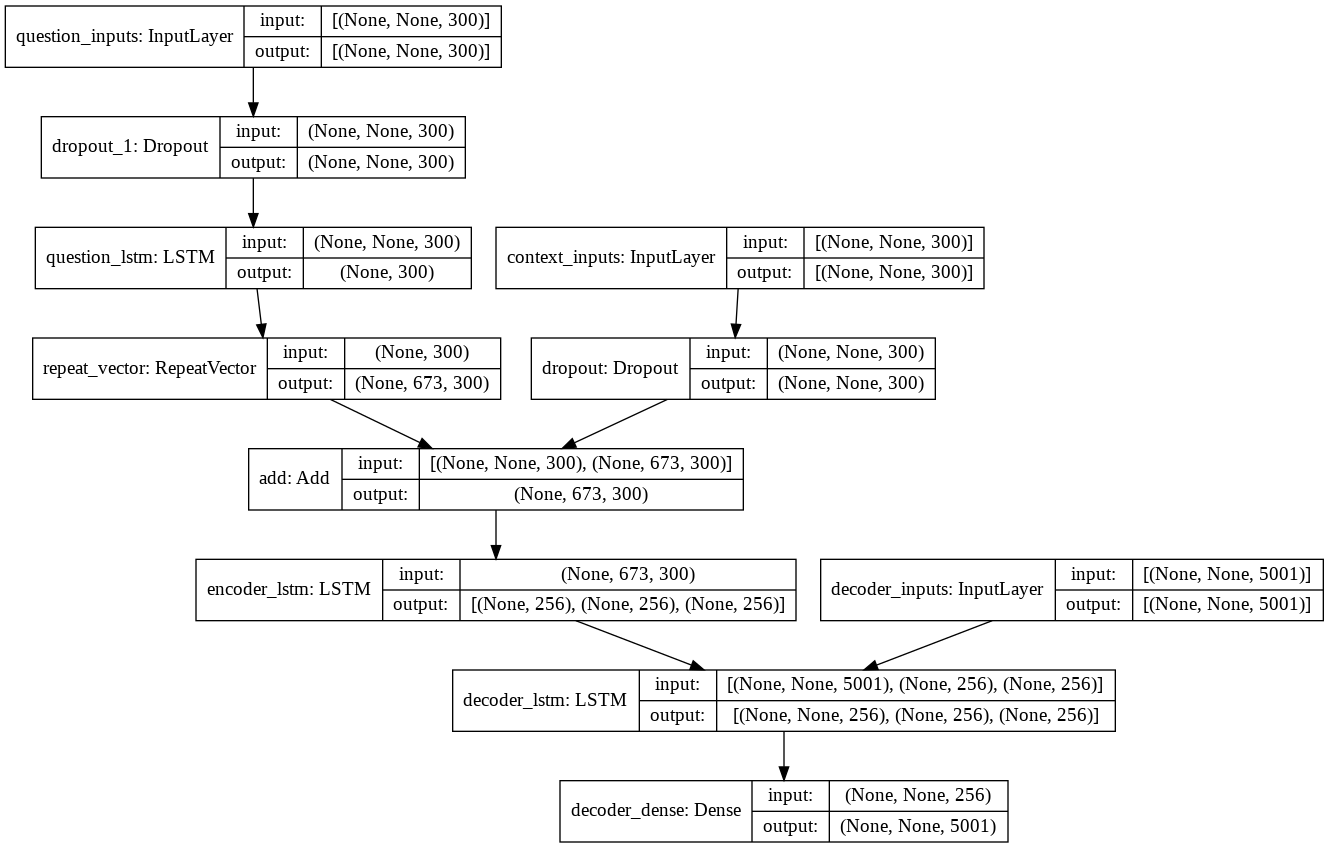

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_glove.png', show_shapes=True)

In [ ]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases
drivepath  = '/content/drive/MyDrive/ProyectoDeepLearningUC/notebooks/'
filepath   = drivepath + 'model_QandA.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, reduce_alpha] 

## 5. Train the model

In [ ]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                           epochs=epochs,
                                           verbose=1, validation_data=test_gen, validation_steps=test_num_batches,
                                           callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
1085/1085 [==============================] - 190s 171ms/step - loss: 0.4542 - accuracy: 0.0208 - val_loss: 0.4592 - val_accuracy: 0.0208

Epoch 00001: val_loss improved from inf to 0.45919, saving model to /content/drive/MyDrive/ProyectoDeepLearningUC/notebooks/model_QandA.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
1085/1085 [==============================] - 196s 181ms/step - loss: 0.4579 - accuracy: 0.0208 - val_loss: 0.4592 - val_accuracy: 0.0208

Epoch 00002: val_loss did not improve from 0.45919
Epoch 3/200
1085/1085 [==============================] - 190s 175ms/step - loss: 0.4578 - accuracy: 0.0208 - val_loss: 0.4592 - val_accuracy: 0.0208

Epoch 00003: val_loss improved from 0.45919 to 0.45915, saving model to /content/drive/MyDrive/ProyectoDeepLearningUC/notebooks/model_QandA.h5
Epoch 4/200
1085/1085 [==============================] - 181s 167ms/step - loss: 0.4578 - accuracy: 0.0208 - val_loss: 0.4591 - val_accuracy: 0.0208

Epoch 00004: val_loss improved from 0.45915 to 0.45909, saving model to /content/drive/MyDrive/ProyectoDeepLearningUC/notebooks/model_QandA.h5
Epoch 5/200
1085/1085 [==============================] - 189s 174ms/step - loss: 0.4578 - accuracy: 0.0208 - val_loss: 0.4590 - val_accuracy: 0.0208

Epoch 00005: val_loss improved from 0.45909 to 0.45900, saving 

## 6. Test the model

In [ ]:
def reply(paragraph, question):
    input_paragraph_seq = []
    input_question_seq = []
    input_paragraph_emb = []
    input_question_emb = []
    input_paragraph_text = paragraph.lower()
    input_question_text = question.lower()
    for word in nltk.word_tokenize(input_paragraph_text):
        if not in_white_list(word):
            continue
        emb = encode_word(word)
        input_paragraph_emb.append(emb)
    for word in nltk.word_tokenize(input_question_text):
        if not in_white_list(word):
            continue
        emb = encode_word(word)
        input_question_emb.append(emb)
    input_paragraph_seq.append(input_paragraph_emb)
    input_question_seq.append(input_question_emb)
    input_paragraph_seq = pad_sequences(input_paragraph_seq, input_paragraph_max_seq_length)
    input_question_seq = pad_sequences(input_question_seq, input_question_max_seq_length)
    states_value = encoder_model.predict([input_paragraph_seq, input_question_seq])
    target_seq = np.zeros((1, 1, num_target_tokens))
    target_seq[0, 0, target_word2idx['START']] = 1
    target_text = ''
    target_text_len = 0
    terminated = False
    while not terminated:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sample_token_idx = np.argmax(output_tokens[0, -1, :])
        sample_word = target_idx2word[sample_token_idx]
        target_text_len += 1

        if sample_word != 'START' and sample_word != 'END':
            target_text += ' ' + sample_word

        if sample_word == 'END' or target_text_len >= target_max_seq_length:
            terminated = True

        target_seq = np.zeros((1, 1, num_target_tokens))
        target_seq[0, 0, sample_token_idx] = 1

        states_value = [h, c]
    return target_text.strip()

In [ ]:
for i in range(20):
    index = i * 150
    paragraph, question, actual_answer = data[index]
    predicted_answer = reply(paragraph, question)
    print('context: ', paragraph)
    print('question: ', question)
    print({'guessed_answer': predicted_answer, 'actual_answer': actual_answer})
    print("\n")

context:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
question:  When did Beyonce start becoming popular?
{'guessed_answer': '', 'actual_answer': 'in the late 1990s'}


context:  Beyoncé's second solo album B'Day was released on September 5, 2006, in the US, to coincide with her twenty-fifth birthday. It sold 541,000 copies in its first week and d